In [8]:
# BLOQUE 1: Limpieza y Construcci√≥n del A√±o T√≠pico (TMY) + Suavizado

import pandas as pd
import os

# Cargar el archivo
ruta_archivo = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_dirty.csv'
df_dirty = pd.read_csv(ruta_archivo)

# Crear columna Timestamp
df_dirty['Timestamp'] = pd.to_datetime(df_dirty[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Definir columnas a trabajar
columnas = ['GHI', 'DNI', 'DHI', 'Tdry', 'Tdew', 'RH', 'Pres', 'Wspd', 'Wdir', 'Snow Depth']

# Asegurar que las columnas son num√©ricas
df_dirty[columnas] = df_dirty[columnas].apply(pd.to_numeric, errors='coerce')

# --- Correcci√≥n de valores f√≠sicos ---
df_dirty['GHI'] = df_dirty['GHI'].clip(lower=0, upper=1500)
df_dirty['DNI'] = df_dirty['DNI'].clip(lower=0, upper=1500)
df_dirty['DHI'] = df_dirty['DHI'].clip(lower=0, upper=1500)

# --- Interpolaci√≥n lineal ---
df_dirty[columnas] = df_dirty[columnas].interpolate(method='linear')
df_dirty[columnas] = df_dirty[columnas].fillna(method='bfill').fillna(method='ffill')

# --- CREAR EL A√ëO T√çPICO COMPLETO ---
# Crear un rango de tiempo 8760 horas (a√±o 2000)
tmy_tiempo = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')

# Crear DataFrame vac√≠o
df_tmy = pd.DataFrame({'Timestamp': tmy_tiempo})

# Asignar datos existentes (ajustar tama√±o)
for col in columnas:
    if len(df_dirty) >= len(df_tmy):
        df_tmy[col] = df_dirty[col].iloc[:len(df_tmy)].values
    else:
        df_tmy[col] = df_dirty[col].values.tolist() + [0]*(len(df_tmy)-len(df_dirty))

# --- SUAVIZADO del GHI, DNI y DHI ---
df_tmy['GHI'] = df_tmy['GHI'].rolling(window=12, center=True, min_periods=1).mean()
df_tmy['DNI'] = df_tmy['DNI'].rolling(window=12, center=True, min_periods=1).mean()
df_tmy['DHI'] = df_tmy['DHI'].rolling(window=12, center=True, min_periods=1).mean()

# Rellenar posibles NaNs
df_tmy.fillna(0, inplace=True)

# Guardar el archivo limpio y estructurado como TMY
ruta_guardado = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'
df_tmy.to_csv(ruta_guardado, index=False)

print("‚úÖ Archivo limpio, suavizado y estructurado como TMY guardado en:", ruta_guardado)



‚úÖ Archivo limpio, suavizado y estructurado como TMY guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv


/tmp/ipykernel_22350/1453167001.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_dirty[columnas] = df_dirty[columnas].fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_22350/1453167001.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmy_tiempo = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')


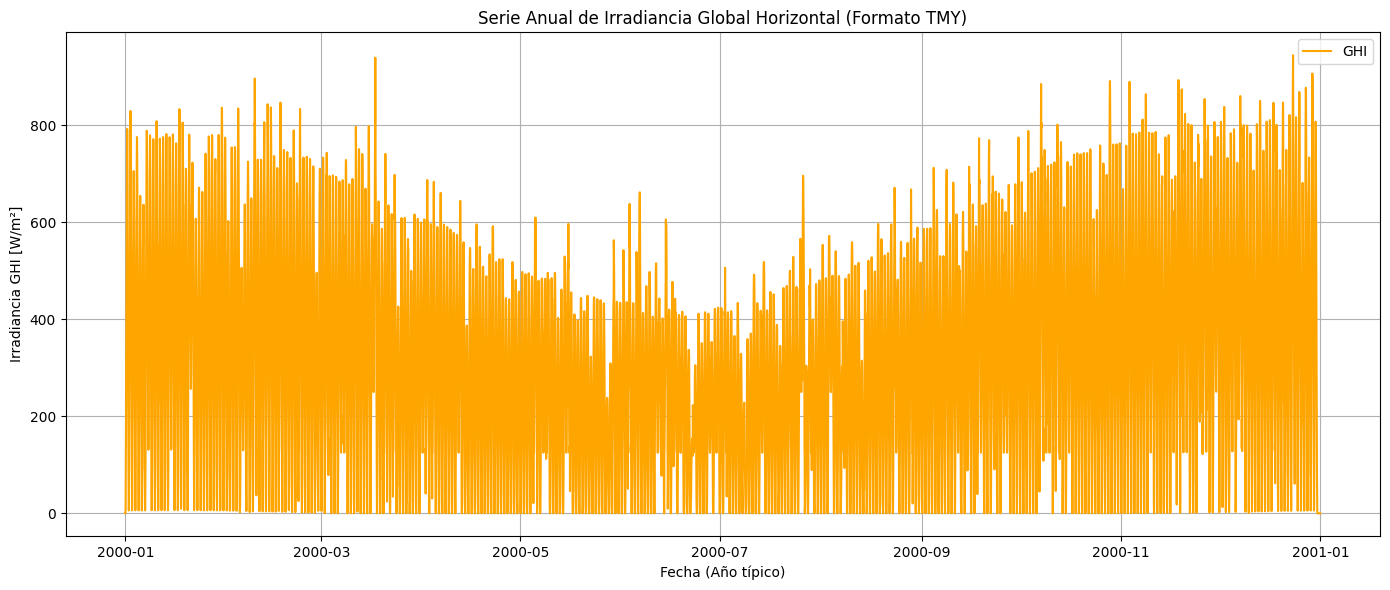

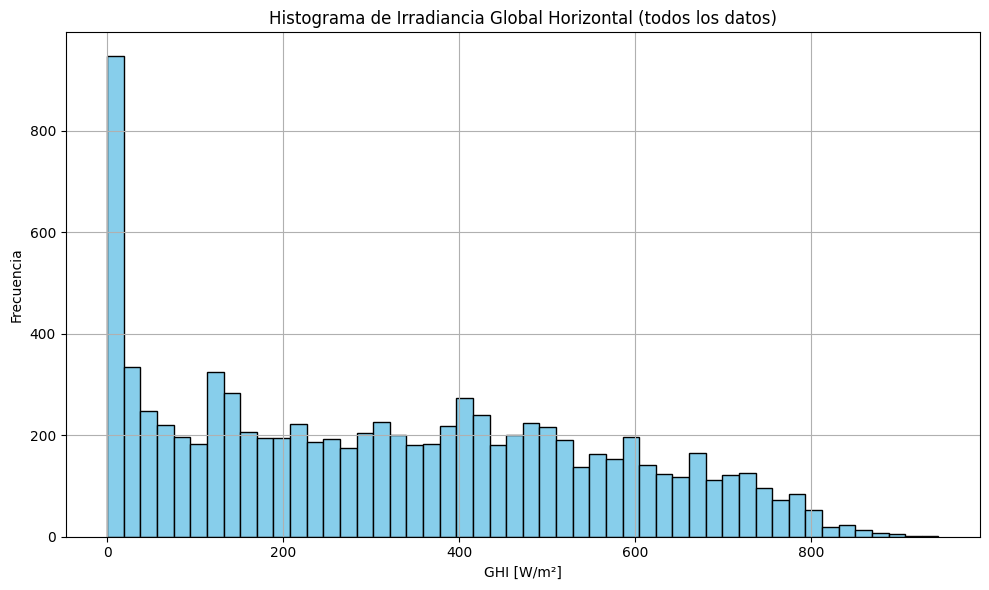

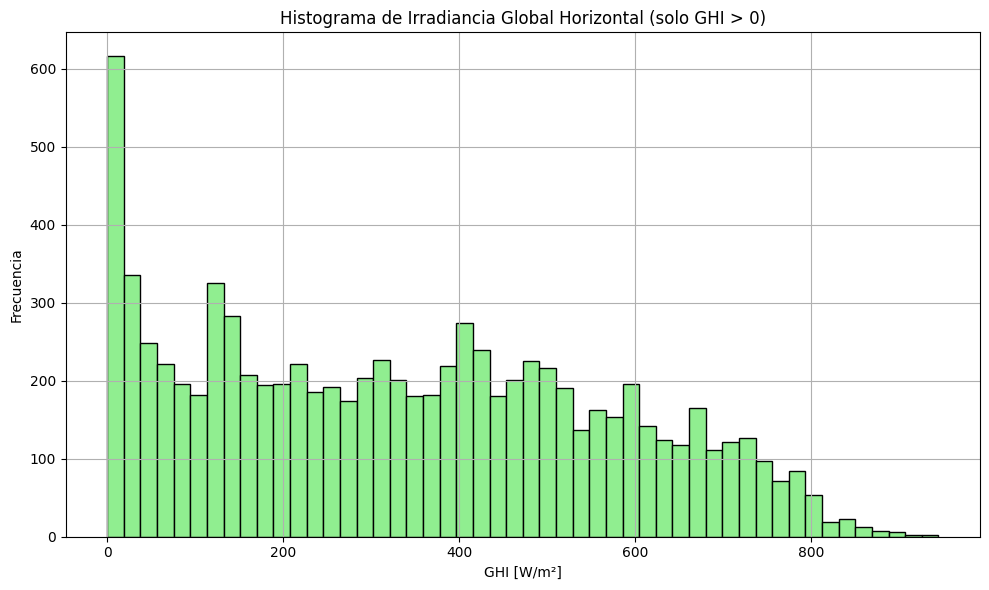

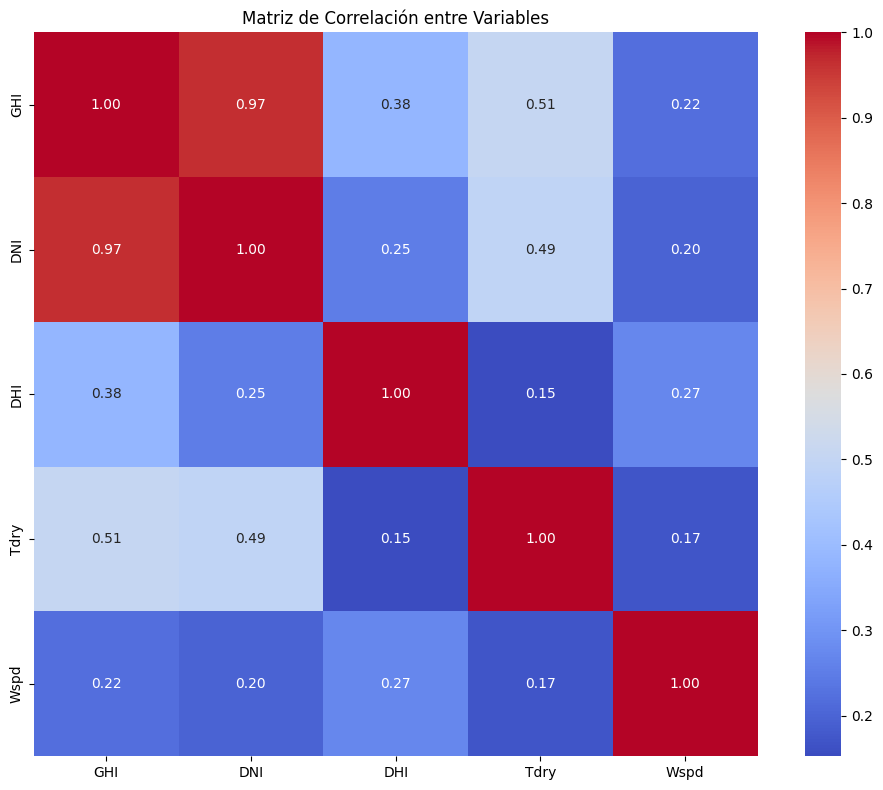

‚úÖ Gr√°ficos guardados en la carpeta: /home/miguelo/datasciencesolar/MiguelOlivares/graficos


In [9]:
# BLOQUE 2: Gr√°ficos de Exploraci√≥n sobre archivo TMY limpio

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ruta del archivo limpio TMY
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'

# Cargar datos
df_tmy = pd.read_csv(ruta_tmy)

# Convertir Timestamp
df_tmy['Timestamp'] = pd.to_datetime(df_tmy['Timestamp'])

# Crear carpeta para guardar gr√°ficos
carpeta_guardado = '/home/miguelo/datasciencesolar/MiguelOlivares/graficos'
os.makedirs(carpeta_guardado, exist_ok=True)

# --- Gr√°fico 1: Serie anual de GHI (Formato TMY)
plt.figure(figsize=(14, 6))
plt.plot(df_tmy['Timestamp'], df_tmy['GHI'], label='GHI', color='orange')
plt.xlabel('Fecha (A√±o t√≠pico)')
plt.ylabel('Irradiancia GHI [W/m¬≤]')
plt.title('Serie Anual de Irradiancia Global Horizontal (Formato TMY)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/serie_anual_GHI_TMY.png')
plt.show()

# --- Gr√°fico 2A: Histograma de GHI (todos los datos)
plt.figure(figsize=(10, 6))
plt.hist(df_tmy['GHI'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('GHI [W/m¬≤]')
plt.ylabel('Frecuencia')
plt.title('Histograma de Irradiancia Global Horizontal (todos los datos)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/histograma_GHI_completo_TMY.png')
plt.show()

# --- Gr√°fico 2B: Histograma solo GHI > 0
df_ghi_solar = df_tmy[df_tmy['GHI'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(df_ghi_solar['GHI'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('GHI [W/m¬≤]')
plt.ylabel('Frecuencia')
plt.title('Histograma de Irradiancia Global Horizontal (solo GHI > 0)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/histograma_GHI_sol_TMY.png')
plt.show()

# --- Gr√°fico 3: Matriz de Correlaci√≥n entre Variables
columnas_corr = ['GHI', 'DNI', 'DHI', 'Tdry', 'Wspd']
matriz_corr = df_tmy[columnas_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlaci√≥n entre Variables')
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/matriz_correlacion_TMY.png')
plt.show()

print(f"‚úÖ Gr√°ficos guardados en la carpeta: {carpeta_guardado}")



In [10]:
# --- BLOQUE: Simulaci√≥n con PySAM usando TMY corregido ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv
from datetime import datetime

# 1. Cargar el TMY corregido
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'
df_tmy = pd.read_csv(ruta_tmy)

# Crear columna Timestamp
df_tmy['Timestamp'] = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')

# 2. Crear columnas para archivo SAM
df_tmy['Year'] = df_tmy['Timestamp'].dt.year
df_tmy['Month'] = df_tmy['Timestamp'].dt.month
df_tmy['Day'] = df_tmy['Timestamp'].dt.day
df_tmy['Hour'] = df_tmy['Timestamp'].dt.hour
df_tmy['Minute'] = 0  # Minuto fijo para PVWatts

# 3. Armar DataFrame para PySAM
df_sam = df_tmy[['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'DHI', 'Tdry', 'Wspd']].copy()
df_sam.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'DHI', 'Temperature', 'Wind Speed']

# 4. Guardar CSV estilo SAM en la carpeta correcta
ruta_sam = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_sam.csv'
with open(ruta_sam, 'w') as f:
    f.write('latitude,longitude,timezone,elevation\n')
    f.write('-23.6,-70.4,-4,1000\n')
    f.write('Year,Month,Day,Hour,Minute,GHI,DNI,DHI,Temperature,Wind Speed\n')
    df_sam.to_csv(f, index=False, header=False)

print(f"‚úÖ Archivo SAM creado y guardado en: {ruta_sam}")

# 5. Simulaci√≥n PySAM
modelo = pv.new()
modelo.SolarResource.solar_resource_file = ruta_sam

# Par√°metros de la planta
modelo.SystemDesign.system_capacity = 100000  # 100 MW
modelo.SystemDesign.dc_ac_ratio = 1.1
modelo.SystemDesign.module_type = 0  # Standard
modelo.SystemDesign.array_type = 1   # Fixed Open Rack
modelo.SystemDesign.tilt = 23
modelo.SystemDesign.azimuth = 0
modelo.SystemDesign.gcr = 0.4
modelo.SystemDesign.inv_eff = 96
modelo.SystemDesign.losses = 14.0

modelo.execute()

# 6. Resultados
energia_kwh = modelo.Outputs.annual_energy
energia_mwh = round(energia_kwh / 1000, 2)

# 7. Guardar resumen
fecha_simulacion = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_resumen = pd.DataFrame({
    "Fecha de Simulaci√≥n": [fecha_simulacion],
    "Capacidad (MW)": [100],
    "DC/AC Ratio": [1.1],
    "Tilt (¬∞)": [23],
    "Azimuth (¬∞)": [0],
    "GCR": [0.4],
    "Eficiencia Inversor (%)": [96],
    "P√©rdidas (%)": [14.0],
    "Energ√≠a Anual (MWh)": [energia_mwh]
})

ruta_resumen = '/home/miguelo/datasciencesolar/MiguelOlivares/resumen_simulacion_100MW_tmy.csv'
df_resumen.to_csv(ruta_resumen, index=False)

print(f"\n‚úÖ Resumen de simulaci√≥n guardado en: {ruta_resumen}")

# 8. Mostrar resumen
print("\nüìã --- RESUMEN DE LA SIMULACI√ìN --- üìã\n")
print(df_resumen.to_string(index=False))


‚úÖ Archivo SAM creado y guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_sam.csv

‚úÖ Resumen de simulaci√≥n guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/resumen_simulacion_100MW_tmy.csv

üìã --- RESUMEN DE LA SIMULACI√ìN --- üìã

Fecha de Simulaci√≥n  Capacidad (MW)  DC/AC Ratio  Tilt (¬∞)  Azimuth (¬∞)  GCR  Eficiencia Inversor (%)  P√©rdidas (%)  Energ√≠a Anual (MWh)
2025-04-26 11:24:16             100          1.1        23            0  0.4                       96          14.0            184904.63


/tmp/ipykernel_22350/1514412128.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tmy['Timestamp'] = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')


In [21]:
# BLOQUE 4: Variables Derivadas (√°ngulo cenital, √≠ndice de claridad, POA)

import pandas as pd
import numpy as np

# Cargar el archivo TMY limpio
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'
df_tmy = pd.read_csv(ruta_tmy)

# Asegurar formato de Timestamp
df_tmy['Timestamp'] = pd.to_datetime(df_tmy['Timestamp'])

# --- C√°lculo del √Ångulo Cenital (Œ∏z) Aprox ---
# Asumimos un modelo simple basado en latitud y d√≠a del a√±o
latitud = -23.6  # Antofagasta

# D√≠a del a√±o
df_tmy['doy'] = df_tmy['Timestamp'].dt.dayofyear

# Declination (Œ¥) aproximada [radianes]
df_tmy['declinacion'] = 23.45 * np.sin(np.deg2rad((360/365)*(284 + df_tmy['doy'])))

# Hora Solar Aproximada
hora_solar = df_tmy['Timestamp'].dt.hour + (df_tmy['Timestamp'].dt.minute / 60)

# √Ångulo horario (h) [grados]
df_tmy['hora_solar'] = hora_solar
df_tmy['angulo_horario'] = (hora_solar - 12) * 15

# C√°lculo Œ∏z (cenital solar) [grados]
df_tmy['theta_z'] = np.arccos(
    np.sin(np.deg2rad(latitud)) * np.sin(np.deg2rad(df_tmy['declinacion'])) +
    np.cos(np.deg2rad(latitud)) * np.cos(np.deg2rad(df_tmy['declinacion'])) *
    np.cos(np.deg2rad(df_tmy['angulo_horario']))
)
df_tmy['theta_z'] = np.rad2deg(df_tmy['theta_z'])

# --- C√°lculo del √çndice de Claridad (kt) ---
# Constante aproximada de irradiancia extraterrestre normal
Gon = 1367  # W/m¬≤

# C√°lculo de irradiancia extraterrestre horizontal
df_tmy['E0h'] = Gon * (1 + 0.033 * np.cos(2 * np.pi * df_tmy['doy'] / 365)) * np.cos(np.deg2rad(df_tmy['theta_z']))

# Asegurar no negativos
df_tmy['E0h'] = df_tmy['E0h'].clip(lower=0)

# √çndice de Claridad kt
df_tmy['kt'] = df_tmy['GHI'] / df_tmy['E0h']
df_tmy['kt'] = df_tmy['kt'].clip(upper=2)  # Control de valores extremos

# --- C√°lculo de Irradiancia POA ---
# Consideramos inclinaci√≥n = 23¬∞, azimut = 0¬∞ (sur)
tilt = 23  # grados
azimuth_panel = 0

# Correcci√≥n simplificada
df_tmy['POA'] = (
    df_tmy['DNI'] * np.cos(np.deg2rad(df_tmy['theta_z'] - tilt)) +
    df_tmy['DHI']
)
df_tmy['POA'] = df_tmy['POA'].clip(lower=0)

# --- Guardar el nuevo archivo con variables derivadas
ruta_features = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_features.csv'
df_tmy.to_csv(ruta_features, index=False)

print("‚úÖ Variables derivadas calculadas y archivo guardado en:", ruta_features)


‚úÖ Variables derivadas calculadas y archivo guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_features.csv


In [22]:
# BLOQUE 4.1: Agregaciones temporales (diario y mensual)

import pandas as pd

# Ruta del archivo TMY ya trabajado
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'

# Cargar archivo
df_tmy = pd.read_csv(ruta_tmy)
df_tmy['Timestamp'] = pd.to_datetime(df_tmy['Timestamp'])

# Agregaci√≥n diaria
df_diario = df_tmy.resample('D', on='Timestamp').mean()

# Agregaci√≥n mensual
df_mensual = df_tmy.resample('M', on='Timestamp').mean()

print("‚úÖ Agregaciones temporales completadas: diario y mensual.")


‚úÖ Agregaciones temporales completadas: diario y mensual.


/tmp/ipykernel_22350/2886441894.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df_tmy.resample('M', on='Timestamp').mean()


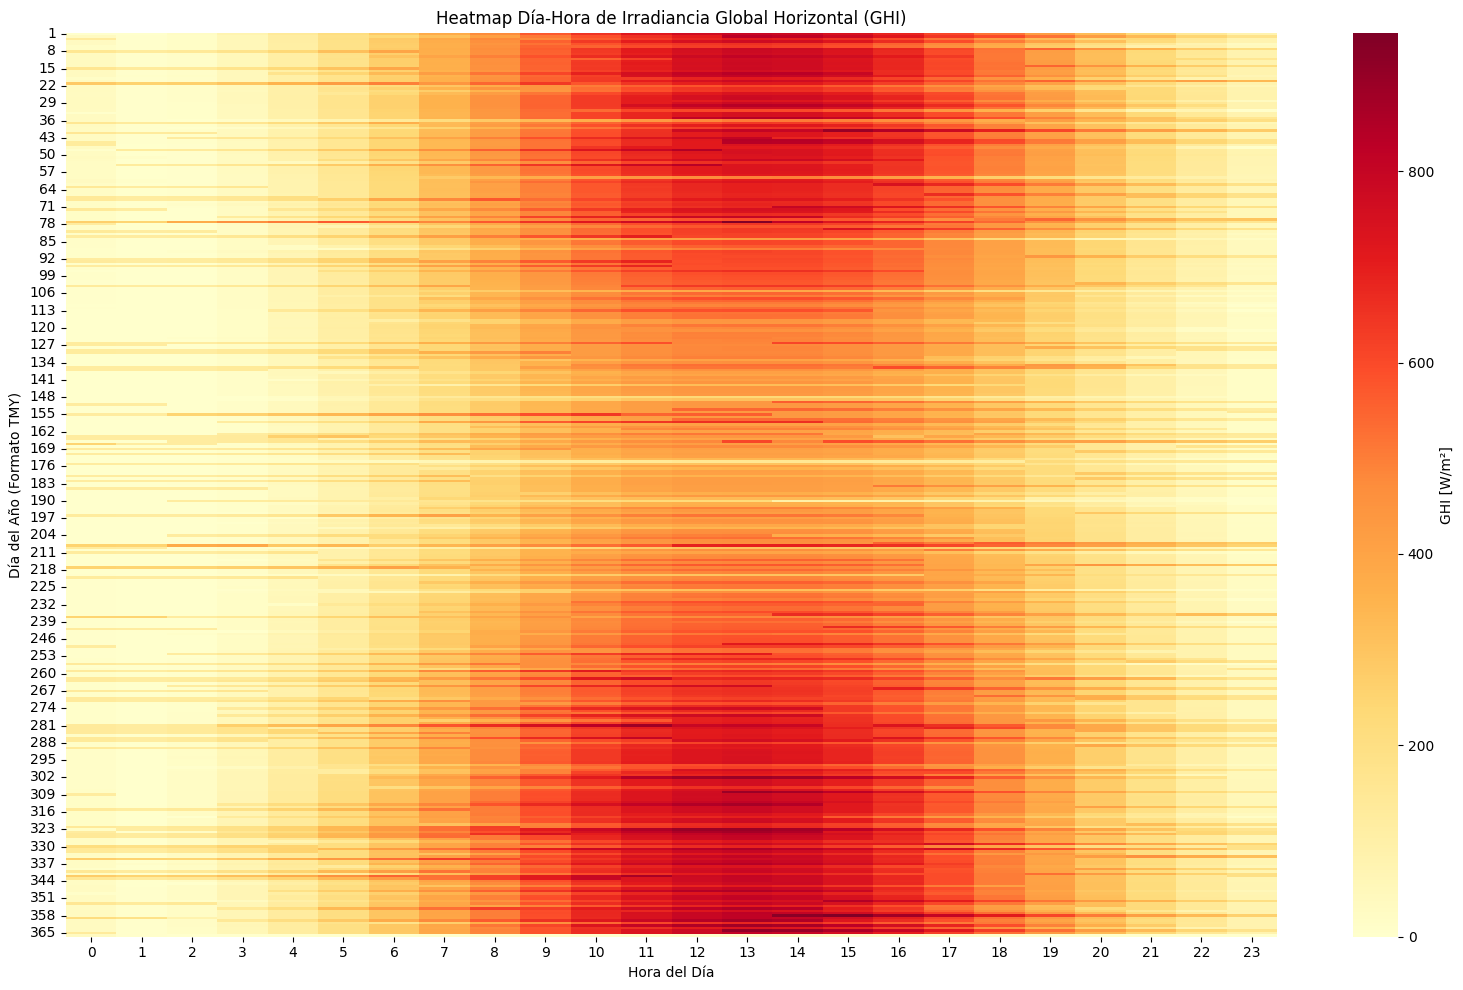

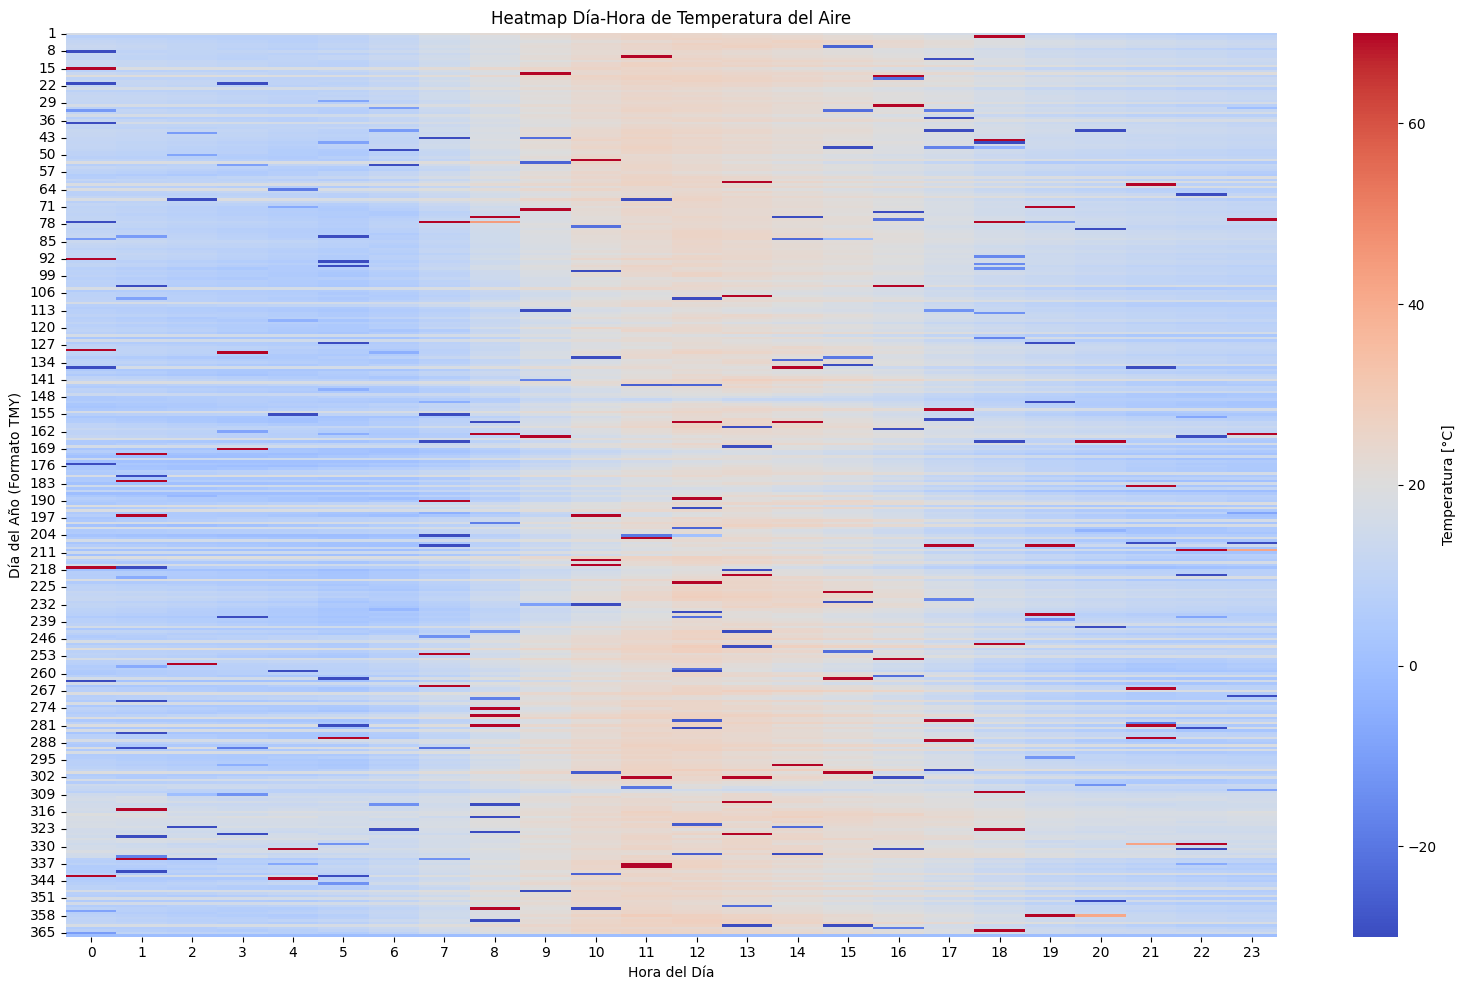

‚úÖ Heatmaps corregidos y guardados en: /home/miguelo/datasciencesolar/MiguelOlivares/graficos_feature


In [20]:
# BLOQUE 4.2: Heatmaps de GHI y Temperatura - Corregido para TMY

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Crear carpeta para guardar gr√°ficos
carpeta_graficos = '/home/miguelo/datasciencesolar/MiguelOlivares/graficos_feature'
os.makedirs(carpeta_graficos, exist_ok=True)

# Crear columnas auxiliares para Mes y Hora
df_tmy['Mes'] = df_tmy['Timestamp'].dt.month
df_tmy['Hora'] = df_tmy['Timestamp'].dt.hour
df_tmy['D√≠a'] = df_tmy['Timestamp'].dt.dayofyear

# --- Heatmap GHI (D√≠a vs Hora)
pivot_ghi = df_tmy.pivot_table(values='GHI', index='D√≠a', columns='Hora')

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_ghi, cmap='YlOrRd', cbar_kws={'label': 'GHI [W/m¬≤]'})
plt.title('Heatmap D√≠a-Hora de Irradiancia Global Horizontal (GHI)')
plt.xlabel('Hora del D√≠a')
plt.ylabel('D√≠a del A√±o (Formato TMY)')
plt.tight_layout()
plt.savefig(f'{carpeta_graficos}/heatmap_GHI_DiaHora_TMY.png')
plt.show()

# --- Heatmap Temperatura (D√≠a vs Hora)
pivot_temp = df_tmy.pivot_table(values='Tdry', index='D√≠a', columns='Hora')

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_temp, cmap='coolwarm', cbar_kws={'label': 'Temperatura [¬∞C]'})
plt.title('Heatmap D√≠a-Hora de Temperatura del Aire')
plt.xlabel('Hora del D√≠a')
plt.ylabel('D√≠a del A√±o (Formato TMY)')
plt.tight_layout()
plt.savefig(f'{carpeta_graficos}/heatmap_Temperatura_DiaHora_TMY.png')
plt.show()

print(f"‚úÖ Heatmaps corregidos y guardados en: {carpeta_graficos}")



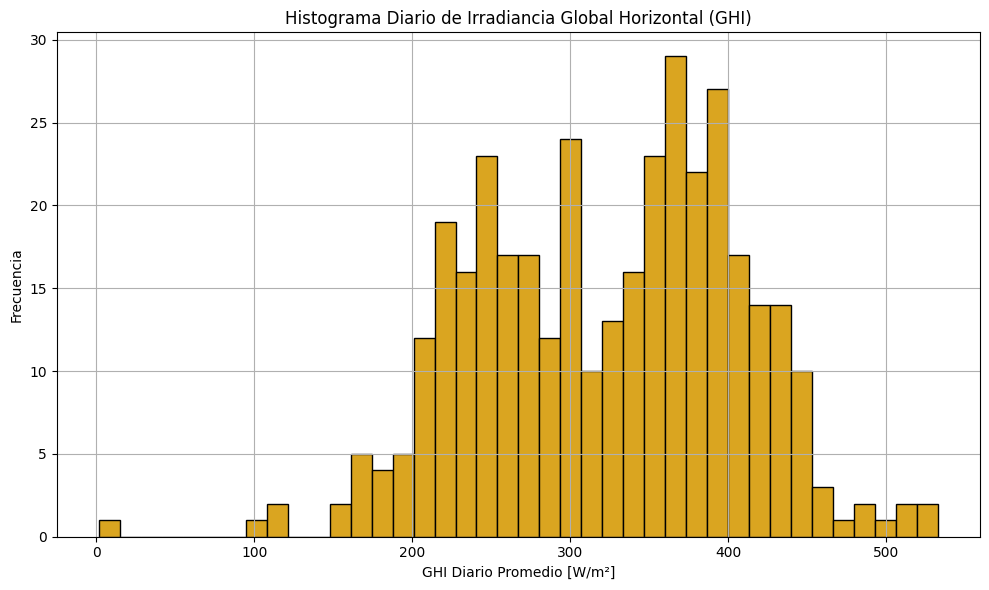

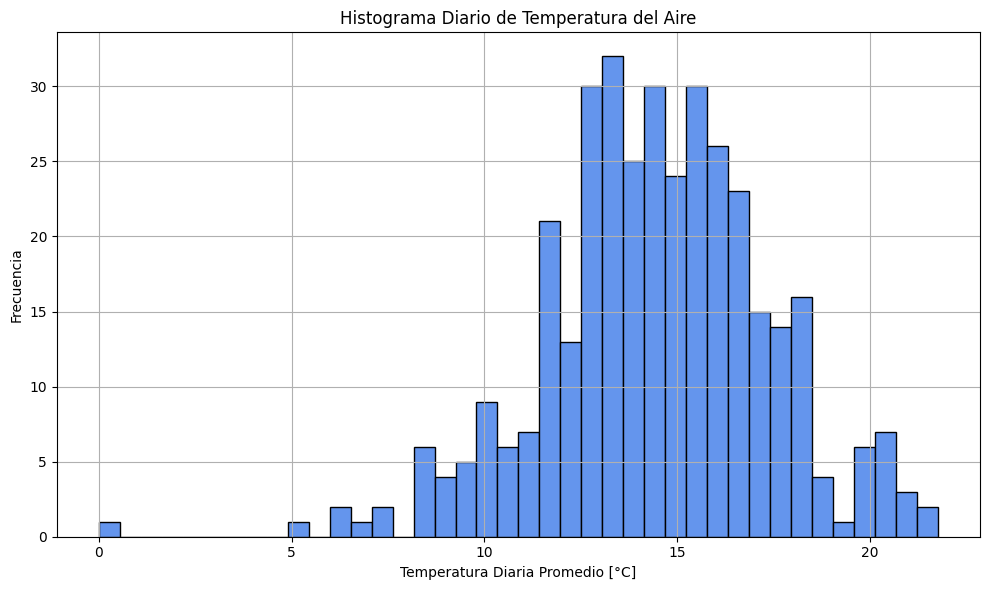

‚úÖ Histogramas guardados en: /home/miguelo/datasciencesolar/MiguelOlivares/graficos_feature


In [23]:
# BLOQUE 4.3: Histogramas de GHI diario y Temperatura diaria

# --- Histograma GHI diario
plt.figure(figsize=(10, 6))
plt.hist(df_diario['GHI'].dropna(), bins=40, color='goldenrod', edgecolor='black')
plt.xlabel('GHI Diario Promedio [W/m¬≤]')
plt.ylabel('Frecuencia')
plt.title('Histograma Diario de Irradiancia Global Horizontal (GHI)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_graficos}/histograma_GHI_diario.png')
plt.show()

# --- Histograma Temperatura diaria
plt.figure(figsize=(10, 6))
plt.hist(df_diario['Tdry'].dropna(), bins=40, color='cornflowerblue', edgecolor='black')
plt.xlabel('Temperatura Diaria Promedio [¬∞C]')
plt.ylabel('Frecuencia')
plt.title('Histograma Diario de Temperatura del Aire')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_graficos}/histograma_Temperatura_diaria.png')
plt.show()

print(f"‚úÖ Histogramas guardados en: {carpeta_graficos}")
